# Project 1 : Networks
Autors : Nicolas Degives, Gauthier Heroufosse, Martine Gandjeto 
Date : 14/10/2021


In [1]:
# Packages
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy
import networkx as nx
import pandas as pd
import re
import community as community_louvain #type:ignore
import community.community_louvain as community_louvain
import math
import time
import random


#import nltk
#nltk.download('punkt')
#nltk.download('words')
#nltk.download('maxent_ne_chunker')


# Part 1: Construction of the co-occurrence Network

## 1.1 Data loading and pre-processing


In [2]:
# Import script
script ="21_Jump_St.txt"
text = []
with open(script,mode="r",encoding="utf8") as input_s:
    text = input_s.read()
    


In [3]:
# Cut in scene
scene = text.split("\t")
#print('\n-----\n'.join(scene))
#print(scene[146])
# Lowercase the text https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/
for i, s in enumerate(scene):
  scene[i] = s.lower()


In [4]:
# List of characters in the moovie
characters = ['Schmidt','Jenko', 'Dickson', 'Walters', 'Domingo', 'Hardy', 'Gordon', 'Samuels', 'Eric',
              'Phyllis','Zack','Roman','Dadier','Principal','Griggs','Annie','Fugazy','Hanson','Doug','Penhall',
              'Terry', 'Melodie', 'Greg', 'Chase', 'Karl', 'Sheila', 'Miranda', 'Captain', 'Amir', 'Emo', 'Juario',
              'Billiam', 'Peter', 'Wendy', 'Molly', 'Delroy', 'Jr', 'Molson', 'Berkeley', 'Garfield', 'Christopher', 'Douglas',
              'Lisa','David','Burns','Sanders','Scott','instructor','Janitor', 'Accompanist']
for i, s in enumerate(characters):
  characters[i] = s.lower()


In [5]:
# Identifications of characters in each scene
sections_dictionary = {}
iterative = 0
for section in scene:
    iterative += 1
    for char in characters:
        if char in section:
            if str(iterative) in sections_dictionary.keys():
                sections_dictionary[str(iterative)].append(char)  
            else:
                sections_dictionary[str(iterative)] = [char]

In [6]:
##set base df (co-occurance matrix)
df = pd.DataFrame(columns = characters, index = characters)
df[:] = int(0) # All values are first equal to zero

#add one for each character-character relationship
#-> in this case, relationship equates to appearing in the same scene
for value in sections_dictionary.values():
    for character1 in characters:
        for character2 in characters:
            if character1 in value and character2 in value:
                df[character1][character2] += 1
                if character1 != character2:
                    df[character2][character1] += 1
#print(df)

## 1.2 Network construction

In [7]:
#add weights to edges
edge_list = []
for index, row in df.iterrows():
    i = 0
    for col in row:
        weight = float(col)/94
        edge_list.append((index, df.columns[i], weight))
        i += 1

#Remove edge if 0.0
updated_edge_list = [x for x in edge_list if not x[2] == 0.0]

#Number of occurance in scenes
node_list = []
for i in characters:
    for e in updated_edge_list:
        if i == e[0] and i == e[1]:
            node_list.append((i, e[2]*6))
for i in node_list:
    if i[1] == 0.0:
        node_list.remove(i)

#remove self references
for i in updated_edge_list:
    if i[0] == i[1]:
        updated_edge_list.remove(i)


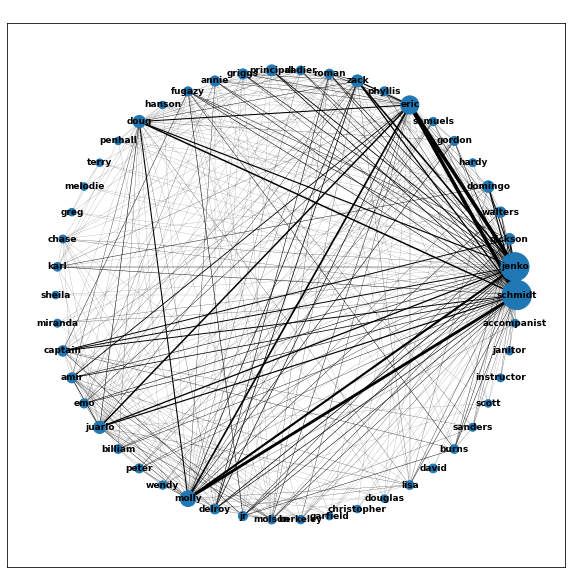

In [8]:
# #networkx graph time!
#networkx graph time!
G = nx.Graph()
for i in node_list:
    G.add_node(i[0], size=i[1])
G.add_weighted_edges_from(updated_edge_list)

# reorder edge list
test = nx.get_edge_attributes(G, 'weight')
updated_again_edges = []
for i in nx.edges(G):
    for x in test:
        if i[0] == x[0] and i[1] == x[1]:
            updated_again_edges.append(test[x])






plt.figure(figsize=(10,10))
plt.title("Weighted co-occurrence network",
          color="white")  # drawing custimization
node_scalar = 100
edge_scalar = 5
sizes = [x[1]*node_scalar+50 for x in node_list]
widths = [x*edge_scalar for x in updated_again_edges]

# draw the graph
pos = nx.layout.circular_layout(G)
custom_colors = ["#FF595E", "#FFCA3A", "#8AC926", "#1982C4", "#6A4C93"]

nx.draw_networkx(G, pos, with_labels=True, font_size=9, font_weight='bold', font_color='black',
                node_size=sizes, width=widths)

plt.show()


## 1.3 Unweighted co-occurrence for k-core detection

In [9]:
# set base df2 (co-occurance matrix)
df2 = pd.DataFrame(columns=characters, index=characters)
df2[:] = int(0)  # All values are first equal to zero

#add one for each character-character relationship
#-> in this case, relationship equates to appearing in the same scene
for value in sections_dictionary.values():
    for character1 in characters:
        for character2 in characters:
            if character1 in value and character2 in value:
                df2[character1][character2] = 1
                df2[character2][character1] = 1


In [10]:
#Identify edges
edge_list2 = []
for index, row in df2.iterrows():
    i = 0
    for col in row:
        if df2[index][i] == 1:
            edge_list2.append((index, df2.columns[i]))
        i += 1
#print(edge_list2)

#Number of occurance in scenes
# We will count the number of time a character appears in the movie
count = {}
for value in sections_dictionary.values():
    for character1 in characters:
        if character1 in value:
          if character1 in count.keys():
            count[character1] += 1
          else:
            count[character1] = 1

# Node list
node_list2 = []
for character1 in characters:
  node_list2.append((character1, count[character1]))

#print(node_list2)


#remove self references
for i in edge_list2:
    if i[0] == i[1]:
        edge_list2.remove(i)


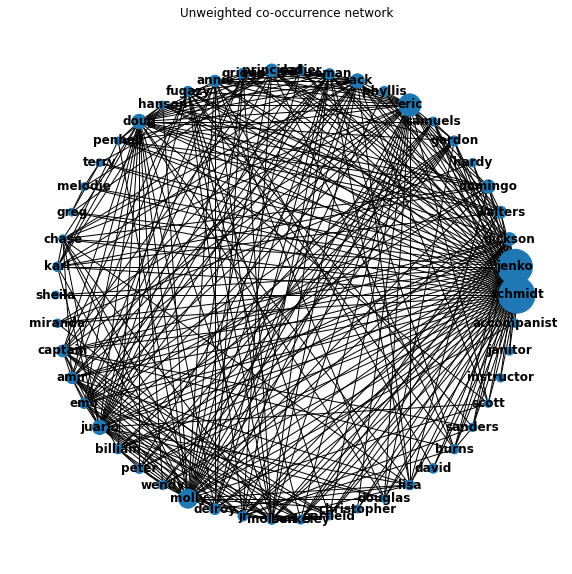

In [11]:
#networkx graph time!
plt.figure(figsize=(10,10))
plt.title("Unweighted co-occurrence network", color="black")

G2 = nx.Graph()
for i in node_list2:
    G2.add_node(i[0], size=i[1])
node_scalar = 10
sizes2 = [x[1]*node_scalar+50 for x in node_list2]

pos=nx.layout.circular_layout(G2)
G2.add_edges_from(edge_list2)
nx.draw(G2, pos, node_size=sizes2, with_labels=True, font_weight='bold')



plt.show()


# Part 2: Analizing the graph

## 2.1 Degree assortativity

Core-periphery structure in this network ?


In [12]:
ass = nx.degree_assortativity_coefficient(G, weight='weight')
print(f"{ass:3.3f}")

-0.276


Disassortativity (negative assortativity) The tendency for nodes to connect to other nodes with dissimilar properties within a network.
-> We need to interpret that, I'll check in the course after



## 2.2 Community detection using Louvain's Algorithm

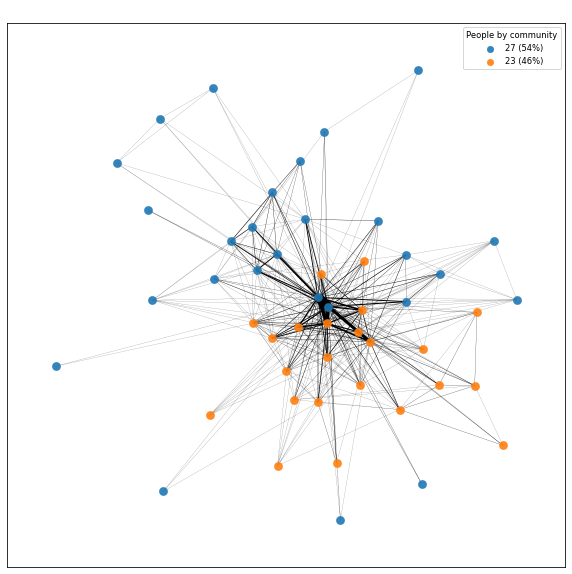

In [13]:
# Community detection with Louvain's algorithm



# Use mean partition of 100 partitions to smooth
boot_partitions = {}
for _ in range(100):
    part = community_louvain.best_partition(G,weight='weight')
    for k, v in part.items():
        if k in boot_partitions:
            boot_partitions[k].append(v)
        else:
            boot_partitions[k] = [v]

partition = {}
for k, v in boot_partitions.items():
    partition[k] = round(sum(v) / len(v))


#partition = community_louvain.best_partition(G)

plt.figure(figsize=(10,10))
plt.title("Community detection",color="white")
#drawing custimization
node_scalar = 100
edge_scalar = 5
sizes = [x[1]*node_scalar+50 for x in node_list]
widths = [x*edge_scalar for x in updated_again_edges]

# draw the graph
pos = nx.spring_layout(G)
custom_colors = ["#FF595E", "#FFCA3A", "#8AC926", "#1982C4", "#6A4C93"]

# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


for i in range(max(partition.values()) + 1):
    pp = len([1 for k, v in partition.items() if v == i])
    pc = 100*pp/len(partition)
    lab = f"{pp} ({round(pc)}%)"
    nx.draw_networkx_nodes(G, pos, nodelist=[k for k, v in partition.items() if v == i],
                           node_color=partition.get(i), linewidths=0.1, node_shape=".", alpha=0.9, label=lab)

nx.draw_networkx_edges(G, pos, width=widths)





# nx.draw_networkx(G, pos, partition.keys(), with_labels=True, font_size=9, font_weight='bold', font_color='black',
#                  node_size=sizes, width=widths, cmap=cmap, node_color=list(
#     partition.values()), labels=lab)





plt.legend(fontsize='small', title_fontsize="small",
           markerscale=0.8, title=f"People by community")

plt.show()


## 2.3 K-core Decomposition

In our case the network is weighted. So we cannot use the standard method to determine the values of k. We need to use the methoology suggested by the professor (slides 41 to 44 of lecture 5). So we need to do some preliminary analysis of the degree  which is below.

In [14]:
# Descriptive statistics of the degree distribution
deg = dict(nx.degree(G, weight='weight')) # Degree of each nodes of the network
pd.Series(deg.values()).describe()  


count    50.000000
mean      0.889362
std       1.434650
min       0.042553
25%       0.191489
50%       0.436170
75%       0.808511
max       7.106383
dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7fd990f38fa0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd99a1b06a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd990f38b80>],
 'medians': [<matplotlib.lines.Line2D at 0x7fd99a1b0dc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fd99a1ba190>],
 'means': []}

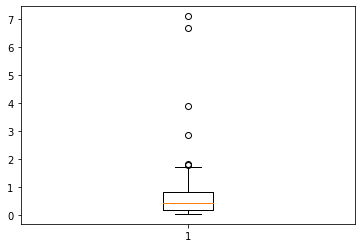

In [15]:
# boxplot
plt.boxplot(deg.values())

Text(0, 0.5, '# of nodes')

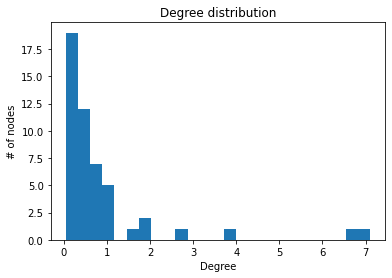

In [16]:
# Histogram
plt.hist(deg.values(),bins=25)
plt.title("Degree distribution")
plt.xlabel("Degree")
plt.ylabel("# of nodes")

Je suggère que nous utilisions les 3 quartiles de la distribution des dégrés comme nos seuils pour les valeurs de k.

In [17]:
# k 
k_values = [0.053191, 0.138298, 0.236702]


In [18]:
# Fonction qui calcule les core pour différentes valeurs de k pour un network weighted
def find_k_cores_weighted(G, k_values, show_details = False):

  # Step 1: Initialization
  # a- Neighbors of each node
  neighbors = {}
  for char in G.nodes():
      for neigh in G.neighbors(char):
          if char not in neighbors.keys():
              neighbors[char] = [neigh]
          else:
              neighbors[char].append(neigh)
                  
  #print(neighbors)

  # b- Degree of each node
  deg = dict(nx.degree(G, weight='weight'))
  #print(deg)

  # c- Pruned
  pruned = {}
  for i in G.nodes():
      pruned[i]= False

  # d- Number of node pruned
  total_pruned = 0

  # Step 2: Determining the k-cores

  k_shells = {}
  while (total_pruned < G.size()):
      for k in k_values:
          if show_details == True:
            print(f"La valeur de k: {k}.")
          to_prune = [i for i in G.nodes() if deg[i] <= k] # Add to the k-core all visited nodes if their strength goes below the threshold k.
          if show_details == True:
            print(f'to_prune est: {to_prune}')
          k_shell = []
          while len(to_prune) > 0:
              i = to_prune.pop(0)
              for j in neighbors[i]:
                  if pruned[j] is False:
                      deg[j] = deg[j] - G.get_edge_data(i, j)['weight']  #https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.get_edge_data.html  
                      if deg[j] <= k:
                          to_prune.append(j)
              pruned[i] = True
              k_shell.append(i)
          total_pruned = total_pruned + 1
          if show_details == True:
            print(f'{k}_shell:{k_shell}')
            print(f'total_pruned est: {total_pruned}')
            print('--------------------------')
          k_shells[k] = list(set(k_shell))
  return k_shells


In [19]:
# Applying the function:
k_cores = find_k_cores_weighted(G, k_values)
k_cores


{0.053191: ['doug',
  'molson',
  'burns',
  'captain',
  'dickson',
  'dadier',
  'jr',
  'fugazy',
  'amir',
  'griggs',
  'schmidt',
  'sheila',
  'molly',
  'sanders',
  'juario',
  'jenko',
  'eric',
  'emo',
  'lisa',
  'delroy',
  'roman',
  'zack'],
 0.138298: ['doug',
  'janitor',
  'molson',
  'melodie',
  'david',
  'hardy',
  'burns',
  'captain',
  'peter',
  'dickson',
  'dadier',
  'jr',
  'fugazy',
  'christopher',
  'amir',
  'griggs',
  'schmidt',
  'sheila',
  'molly',
  'sanders',
  'juario',
  'jenko',
  'eric',
  'emo',
  'greg',
  'terry',
  'lisa',
  'delroy',
  'miranda',
  'roman',
  'instructor',
  'domingo',
  'zack'],
 0.236702: ['doug',
  'penhall',
  'walters',
  'garfield',
  'janitor',
  'molson',
  'melodie',
  'david',
  'principal',
  'billiam',
  'hanson',
  'phyllis',
  'hardy',
  'burns',
  'berkeley',
  'captain',
  'scott',
  'peter',
  'wendy',
  'annie',
  'dickson',
  'dadier',
  'jr',
  'fugazy',
  'douglas',
  'accompanist',
  'christopher'

# Part 3: Comparison with the Babarasi-Albert model

Comparaison with the Barabasi-albert graph

50 6.96


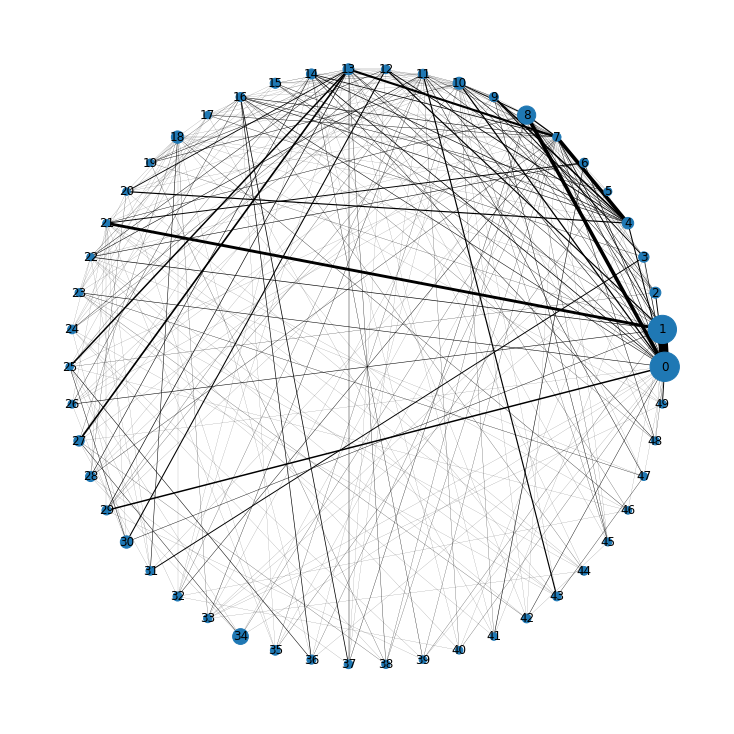

In [20]:

n = G.number_of_nodes()
m= G.number_of_edges()/n
print(n,m)

ba = nx.barabasi_albert_graph(n,int(m))

pos2=nx.layout.circular_layout(ba)

plt.figure(figsize=(10,10))
nx.draw(ba, pos2 ,with_labels=True, node_size=sizes, width=widths)
plt.show()


# xdata =[]
# ydata = []

# for i,j in ba.edges():
#   xdata.append(ba.degree(i));ydata.append(ba.degree(j))
#   xdata.append(ba.degree(j));ydata.append(ba.degree(i))

# plt.plot(xdata,ydata,'o',alpha=0.05)
# plt.show()



Degree assortativity of the Barabasi-albert graph


In [21]:
ass1 = nx.degree_assortativity_coefficient(ba)
print(f"{ass1:3.3f}")

-0.234


Community detection of the Barabasi-Albert graph using Louvain's algorithms

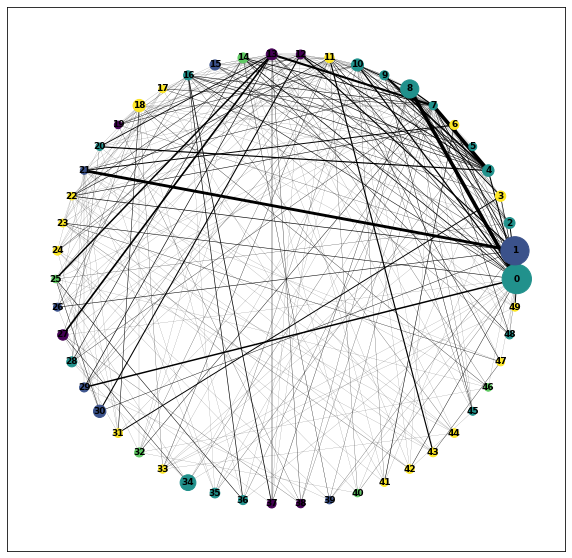

In [22]:
# Community detection with Louvain's algorithm

# compute the best partition
partition1 = community_louvain.best_partition(ba)

plt.figure(figsize=(10, 10))

# draw the graph
pos = nx.layout.circular_layout(ba)

# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition1.values()) + 1)

nx.draw_networkx(ba, pos, partition1.keys(), with_labels=True, font_size=9, font_weight='bold', font_color='black',
                 node_size=sizes, width=widths, cmap=cmap, node_color=list(
                     partition1.values()))


plt.show()

# Part 4: Influence Maximization problem

## Greedy Implementation of the Influence Maximization Problem

In [23]:
# ---


def generate_active_edges(graph:nx.Graph, p:float) -> nx.Graph:
    """
    :param graph: the initial graph
    :param p: probability threshold for edges activation
    :return: the graph with some activated edges
    """

    g = graph.copy()

    edges = list(g.edges)
    edges_weight = np.array([graph[u][v].get('weight', 1) for u, v in graph.edges])

    # As the instruction does not specify what percentage of activated edges we have to take, we have chosen to use multinomial experiments.
    # But we left the possibility to enforce a certain percentage of activated edges as well.
    if p is not None and p > 0:
        edges_mapped = {i:n for i,n in enumerate(g.edges.keys())}
        activated_edges = random.choices(range(len(edges)), edges_weight, k = round(len(edges)*p))
        for activated in activated_edges: 
            u,v = edges_mapped.get(activated) 
            g[u][v]['activated'] = True
    else:
        edges_proba = edges_weight/sum(edges_weight)
        activated_edges = np.random.multinomial(len(edges), edges_proba) > 0
        for activated, (u, v, info) in zip(activated_edges, g.edges.data()): g[u][v]['activated'] = activated

    return g

def get_accessible_neighbors(g: nx.Graph, node:nx.nodes) -> list:
    """
    :param g: the graph
    :param node: the root node
    :return: the list of accessible node's neighbors
    """
    accessible_neighbors = []
    for neighbor in g.neighbors(node):
        if g[node][neighbor].get('activated', False):
            accessible_neighbors.append(neighbor)

    return accessible_neighbors

def get_number_accessible_neighbors(g:nx.Graph, A0:list) -> dict:
    """
    :param g: the graph
    :param A0: starting nodes from which we have to retrieve accessible neighbors
    :return: dict(n= number of accessible neighbors, accessible_neighbors= the list of accessible neighbors)
    """
    neighbors = A0[:]
    new_neighbors = A0[:]
    while new_neighbors:
        node = new_neighbors.pop()
        new_neighbors += get_accessible_neighbors(g, node)
        new_neighbors = list(set(new_neighbors) - set(neighbors))
        neighbors += new_neighbors

    n = len(neighbors)
    return dict(
        n=n,
        accessible_neighbors=neighbors
    )

def greedy_influence_maximisation_problem(graph:nx.Graph, k:int, n:int, p:float) -> list:
    """
    :param graph: the graph
    :param k: the number of best nodes we would like to return
    :param n: the number of simulations to retrieve best nodes
    :param p: the probability threshold to active an edge
    :return: the list of most influential nodes
    """
    A0 = []
    graphs = [generate_active_edges(graph, p) for _ in range(n)]

    for _ in range(k):
        nodes_to_test = list(set(graph.nodes) - set(A0))
        nodes_score = dict(zip(nodes_to_test, [0]*len(nodes_to_test)))
        for node in nodes_to_test:
            for g in graphs:
                accessible_dict = get_number_accessible_neighbors(g, A0+[node])
                nodes_score[node] += accessible_dict.get('n')

        # Retrieve the max
        best_node = max(nodes_score, key=nodes_score.get)
        A0.append(best_node)

    return A0


k = round(len(G.nodes()) * 0.06) # Like this we get the best 3 nodes
n = len(G.nodes()) * 10
p = 0.1

A0 = greedy_influence_maximisation_problem(G, k, n, p)

print(f"Best {k} nodes with {n} simulations : {A0}")



Best 3 nodes with 500 simulations : ['schmidt', 'jenko', 'eric']


In [24]:
# ---
# Independant Cascade Model

def independent_cascade_model(graph: nx.Graph, active_nodes: list, p: float) -> dict:
    """
    :param graph: the graph
    :param active_nodes: starting nodes from which we spread
    :param p: the probability threshold to activate a node
    :return: dict(spread = number of activated nodes, list_active= the list of active ndoes)
    """
    g = graph.copy()

    already_active = set(active_nodes[:])
    to_propagate = active_nodes[:]

    while to_propagate:
        active = to_propagate.pop()
        neighbors = list(g.neighbors(active))
        tried = []
        for nei in neighbors:
            if nei in already_active:
                continue
            activation = random.random() < p
            if activation:
                g[active][nei]['activated'] = True
                to_propagate.append(nei)
                already_active.add(nei)
            else:
                g[active][nei]['tried'] = True

    spread = len(already_active)
    return {'spread': spread, 'list_active': already_active}


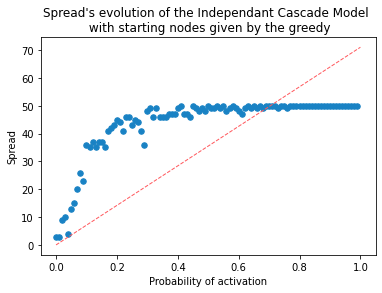

In [25]:
# Mean spread of cascade model
all_spread_cascade = []
X = np.arange(0, 1, 1/100)

for p in X:
    spread, _ = independent_cascade_model(G, A0, p).values()
    all_spread_cascade.append(spread)


fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(X, all_spread_cascade, s=30, c=custom_colors[3])
plt.title("Spread's evolution of the Independant Cascade Model \n with starting nodes given by the greedy")
plt.xlabel("Probability of activation")
plt.ylabel("Spread")
ax.plot([0, 1], [0, 71], c=custom_colors[0], linestyle="dashed", linewidth=1)
plt.show()